# `FL004_decoding`

In [1]:
%load_ext watermark
%watermark -a "Etienne Ackermann," -n -t -v -p nelpy,numpy,scipy,pandas

C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


Etienne Ackermann, Sun Dec 03 2017 21:55:19 

CPython 3.6.3
IPython 6.1.0

nelpy 0.1.1
numpy 1.12.1
scipy 0.19.1
pandas 0.21.0


# Overview

Here I want to decode a few run bouts, using (i) raw 2D tuning curves, (ii) idealized 2D tuning curves, and (iii) linearized variants.

I also want to get spike rasters to line up nicely during run bouts.

Then, I want to repeat the above, but on SWR candidate events.

This notebook therefore does not augment or mutate the data in any way, and doesn't even really play an important role in our analyses. However, it's good to check and visually identify a few events that we expect should be identified by our subsequent analyses.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

%matplotlib inline

warnings.filterwarnings("ignore")

C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
fileroot = '../../../../neoReader/' 
infile = 'FrankLabData-BonConFra-no-eeg03b.nel' # saved with Pandas=0.21
infile = 'FrankLabData-BonConFra-no-eeg06d.nel' # saved with Pandas=0.21
outfile = 'FrankLabData-BonConFra-no-eeg04.nel' # saved with Pandas=0.21
FrankLabData = nel.load_pkl(fileroot + infile) 
data = FrankLabData.data
sessions = FrankLabData.sessions

# Quick demo of what we're looking for

Below, we show an event that was recorded while animal Bon was in environment E2, but the [linearized] decoding is being done using place cells and place fields from E1. More specifically, and more accurately, we use the place fields from the first run on E1, namely E1a.

The decoding overlay here is just approximately correct, in that the scaling is not precise. But the relative trajectory is good, so we get a good sense of whether things work as expected or not.

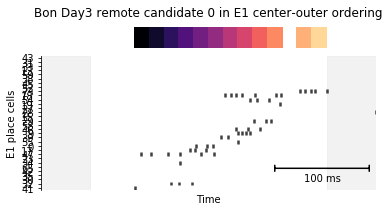

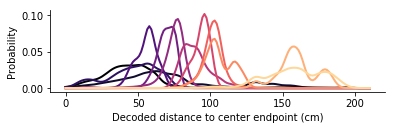

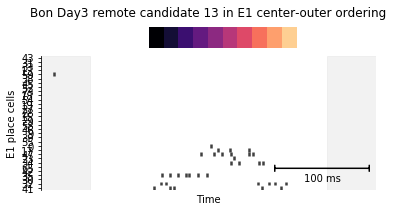

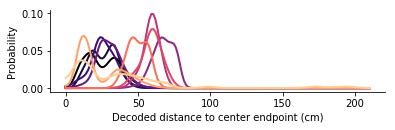

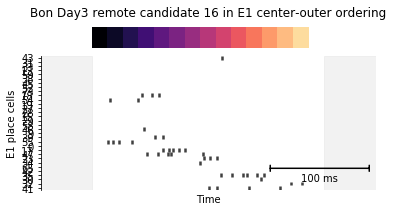

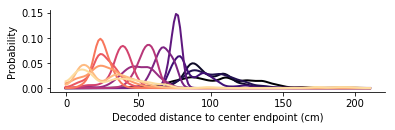

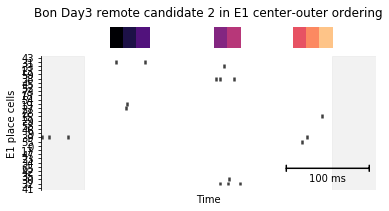

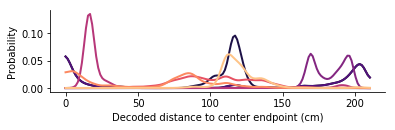

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

E1a, E1b, E2 = 1, 3, 5
animal, day = 'Bon', 'Day3'

evt_idxs = [0, 13, 16, 2] # look at paper events, 0, 13, 16, 2
# Also, look at R2-sig, HMM-non-sig @ P < 0.05: 10 18 19 21  ---> all seem to be CORRECTLY discarded by HMM?
# Also, look at R2-sig, HMM-non-sig @ P < 0.03: 10 15 18 19 21 26 34

for evt_idx in evt_idxs:

    bst = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates'][evt_idx]
    tc = data[animal][day]['tuning_curves1D_center'][E1b]
    evt_extent = bst.support
    plot_extent = evt_extent.expand(0.05)
    st = data[animal][day]['remote_replay_E1_in_E2']['st_placecells_remote'][plot_extent]
    peak_order = tc._unit_subset(st.unit_ids).get_peak_firing_order_ids()

    fig1, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax = npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5)
    npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9')
    ax.set_xlim(*st.support.time)
    npl.add_scalebar(ax=ax, sizex=0.1, labelx='100 ms', hidey=False, hidex=False)
    npl.utils.clear_right()
    npl.utils.clear_top_bottom()
    plt.ylabel('E1 place cells')
    plt.xlabel('Time')
    # ymin, ymax = ax.get_ylim()
    posterior, lengths, mode_pth, mean_pth = nel.decoding.decode1D(bst=bst, ratemap=tc.smooth(sigma=4))
    # plt.plot(bst.bin_centers, mode_pth*ymax / tc.bin_centers[-1])

    divider = make_axes_locatable(ax)
    axBins = divider.append_axes("top", size=0.3, pad=0.1)

    bins = np.atleast_2d(posterior.sum(axis=0))
    non_empty_idx = np.argwhere(~np.isnan(bins))[:,1]
    n_non_empty = len(non_empty_idx)
    bins[:,non_empty_idx] = np.arange(n_non_empty)

    NUM_COLORS = n_non_empty
    cm = plt.get_cmap('magma')
    # cm = plt.get_cmap('jet')
    clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    npl.set_palette(clist)
    nan_jet = ListedColormap(clist, name='nan_jet')

    axBins.pcolor(bst.bins, [0,1,], bins, cmap=nan_jet)
    axBins.set_xlim(ax.get_xlim())
    npl.utils.clear_left_right(axBins)
    npl.utils.clear_top_bottom(axBins)

    axBins.set_title('{} {} remote candidate {} in E1 center-outer ordering'.format(animal, day, evt_idx), y=1.2)
    plt.show()

    fig2, ax = plt.subplots(1, 1, figsize=(6, 1.5))
    for post in posterior.T:
        if not any(np.isnan(post)):
            plt.plot(tc.bin_centers, post, lw=2);
    plt.xlabel('Decoded distance to center endpoint (cm)')
    plt.ylabel('Probability')
    npl.utils.clear_right()
    npl.utils.clear_top()

    # npl.savefig('raster-{}a'.format(evt_idx), fig=fig1)
    # npl.savefig('raster-{}b'.format(evt_idx), fig=fig2)
    
    plt.show()

# Plot some examples from Bon Day3

In [109]:
E1a, E1b, E2 = 1, 3, 5
animal = 'Bon'
day = 'Day3'
data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates']

good_examples = [5, 16, 20, 26, 34, ]

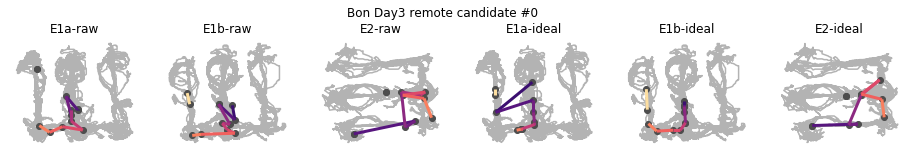

pdf saved successfully...
png saved successfully...


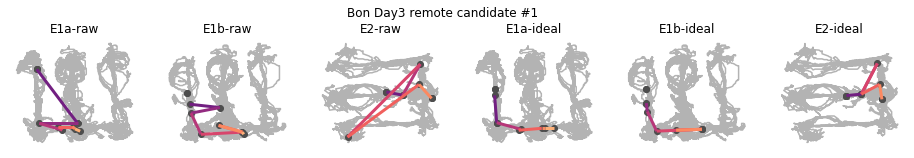

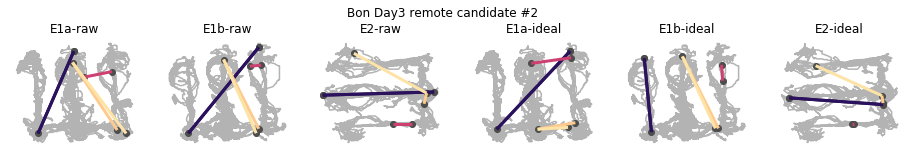

pdf saved successfully...
png saved successfully...


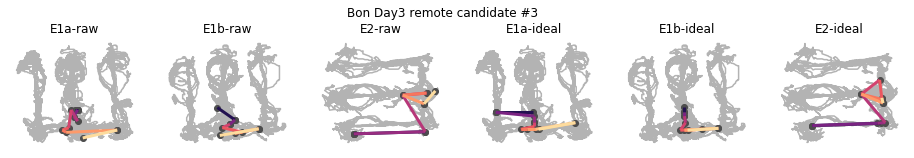

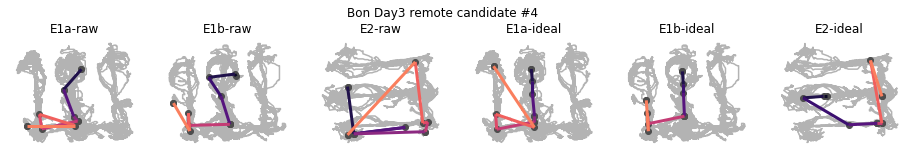

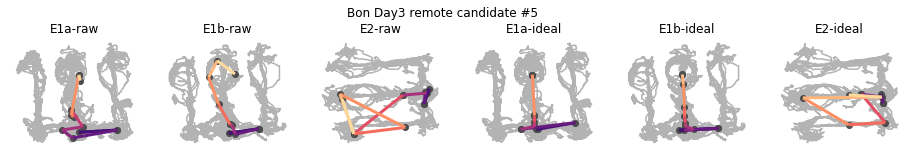

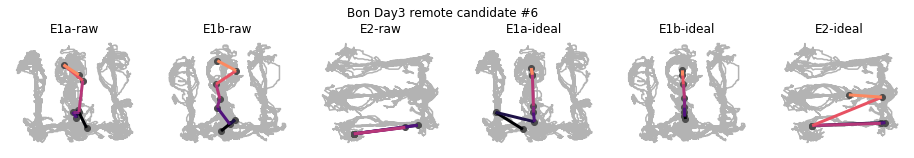

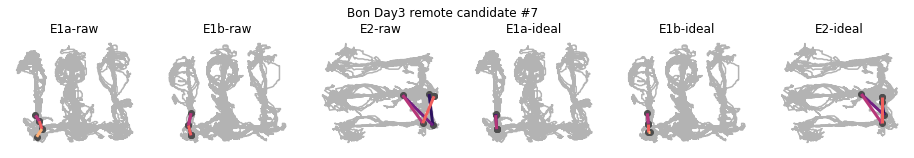

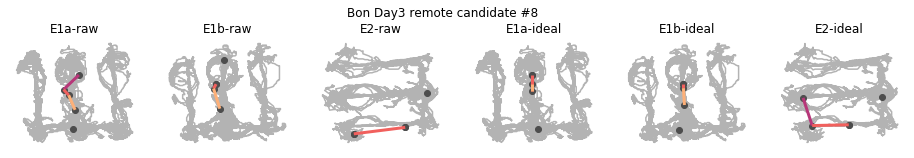

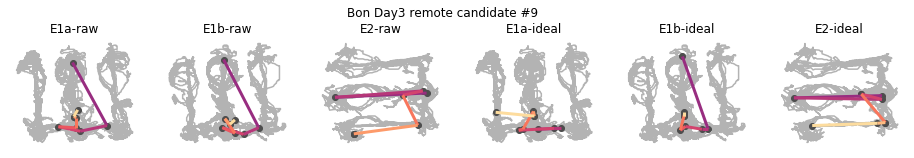

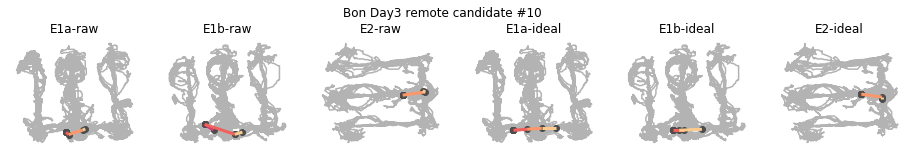

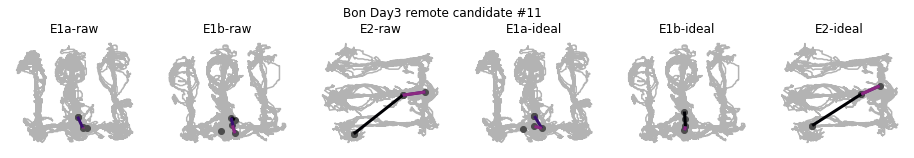

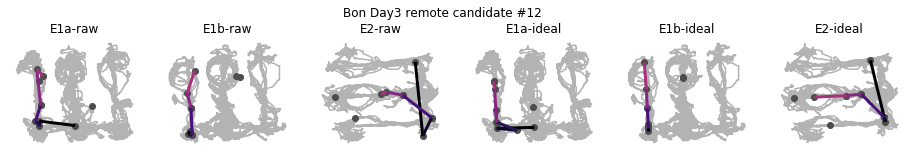

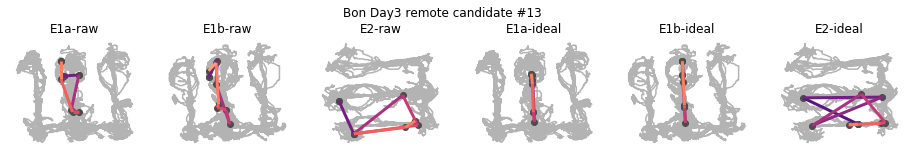

pdf saved successfully...
png saved successfully...


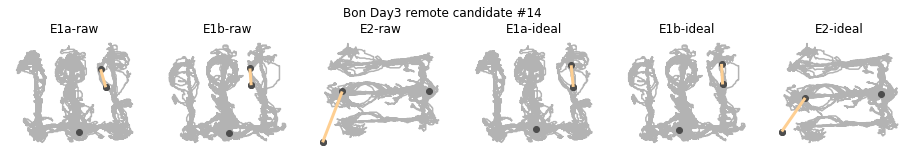

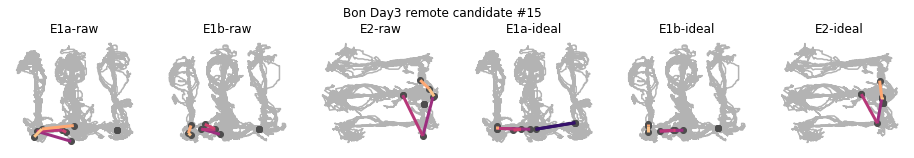

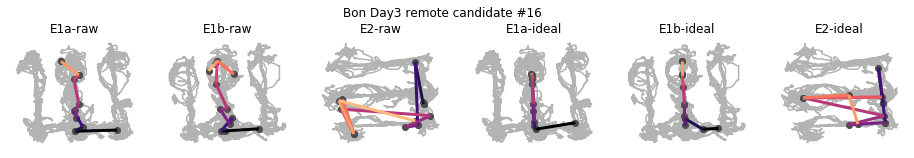

pdf saved successfully...
png saved successfully...


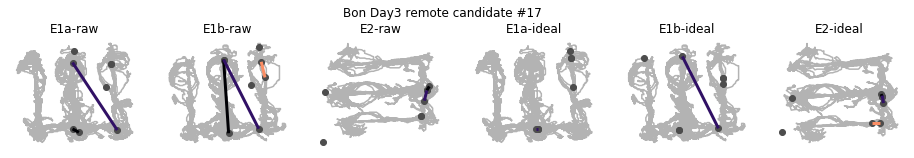

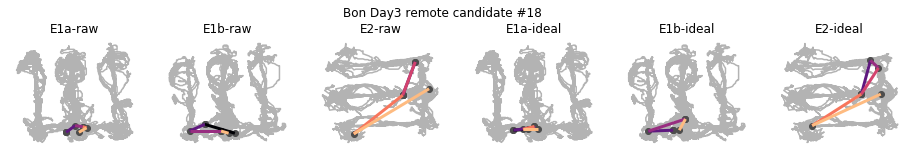

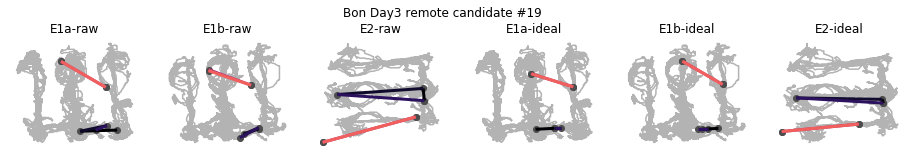

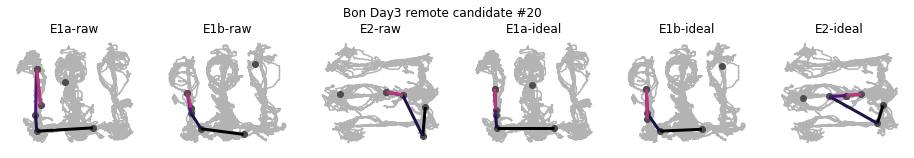

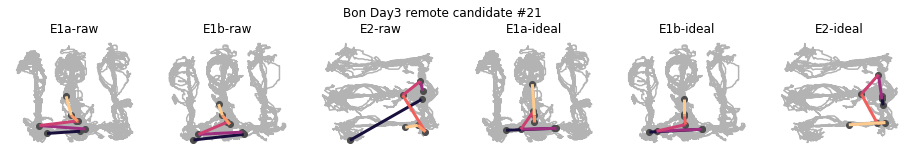

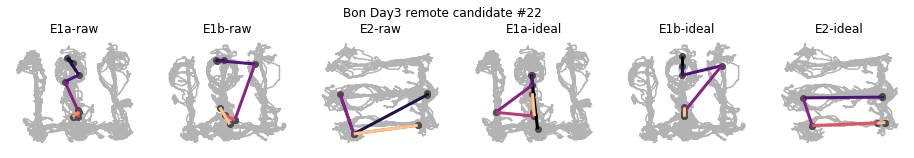

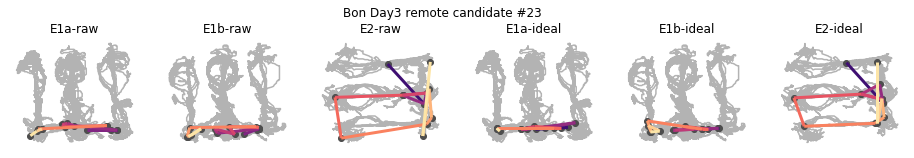

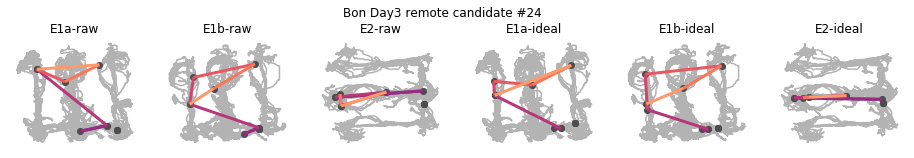

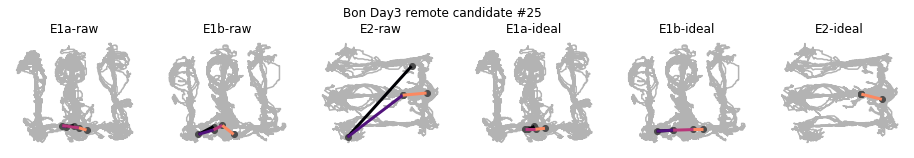

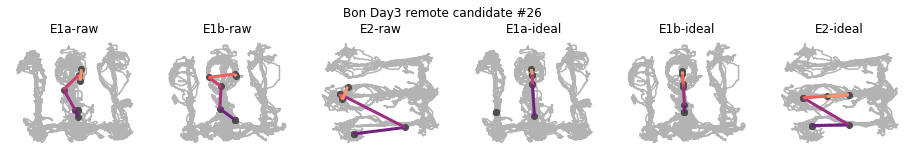

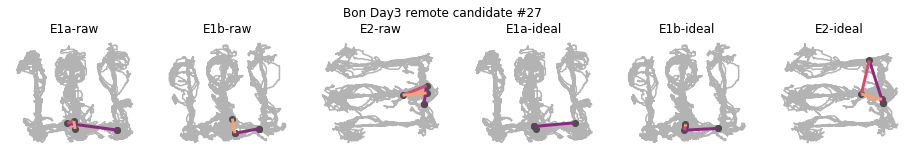

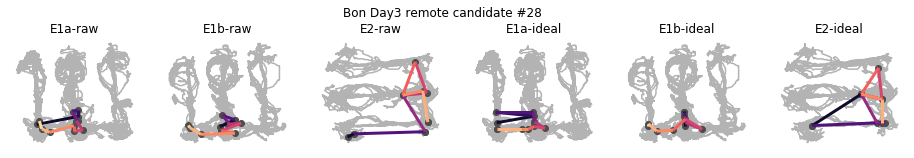

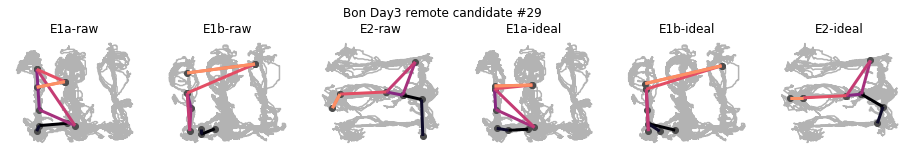

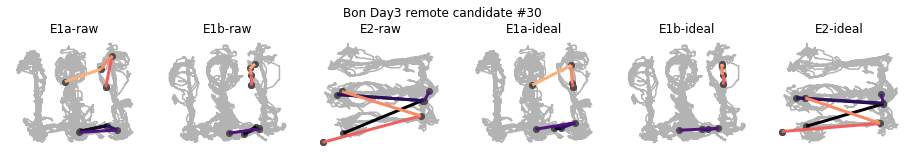

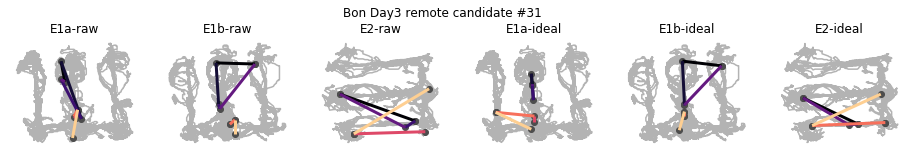

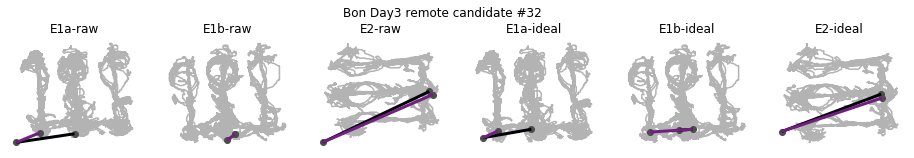

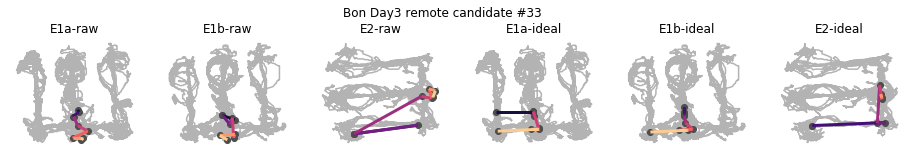

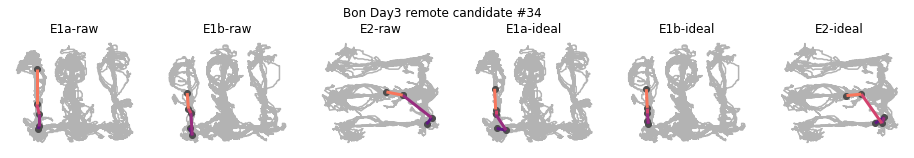

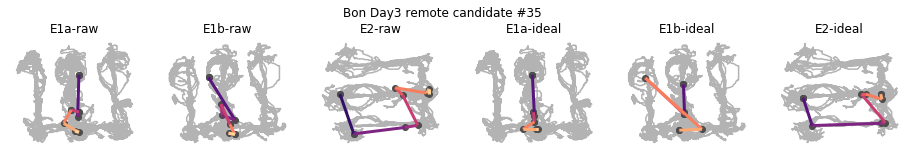

In [12]:
def plot_all_remote_E2_events(data, animal, day):
    try:
        bst = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates']
    except KeyError:
        raise UserWarning('The (animal, day) pair does not have remote replay analysis results...')
        return
    
    tc_E1a = data[animal][day]['tuning_curves2D'][E1a]
    tc_E1b = data[animal][day]['tuning_curves2D'][E1b]
    tc_E2 = data[animal][day]['tuning_curves2D'][E2]
    
    tc_E1a_ideal = data[animal][day]['tuning_curves2D_ideal'][E1a]
    tc_E1b_ideal = data[animal][day]['tuning_curves2D_ideal'][E1b]
    tc_E2_ideal = data[animal][day]['tuning_curves2D_ideal'][E2]
    
    pos_E1a = data['Bon']['Day3']['pos'][E1a]
    pos_E1b = data['Bon']['Day3']['pos'][E1b]
    pos_E2 = data['Bon']['Day3']['pos'][E2]

    for idx in range(bst.n_epochs):
        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16, 2))
        axes = (ax1, ax2, ax3, ax4, ax5, ax6)
        
        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E1a)
        npl.plot2d(pos_E1a, color='0.7', ax=ax1)
        ax1.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax1, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax1.set_title('E1a-raw')
        
        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E1b)
        npl.plot2d(pos_E1b, color='0.7', ax=ax2)
        ax2.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax2, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax2.set_title('E1b-raw')
        
        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E2)
        npl.plot2d(pos_E2, color='0.7', ax=ax3)
        ax3.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax3, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax3.set_title('E2-raw')
        
        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E1a_ideal)
        npl.plot2d(pos_E1a, color='0.7', ax=ax4)
        ax4.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax4, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax4.set_title('E1a-ideal')
        
        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E1b_ideal)
        npl.plot2d(pos_E1b, color='0.7', ax=ax5)
        ax5.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax5, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax5.set_title('E1b-ideal')

        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E2_ideal)
        npl.plot2d(pos_E2, color='0.7', ax=ax6)
        ax6.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax6, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax6.set_title('E2-ideal')
        
        fig.suptitle('{} {} remote candidate #{}'.format(animal, day, idx), y=1.1)
        
        for ax in axes:
            npl.utils.clear_left_right(ax)
            npl.utils.clear_top_bottom(ax)
            
        plt.show()
        
#         if idx in [0,2,13,16]:
#             npl.savefig('traj-{}'.format(idx), fig=fig)
        
plot_all_remote_E2_events(data=data, 
                          animal=animal,
                          day=day)

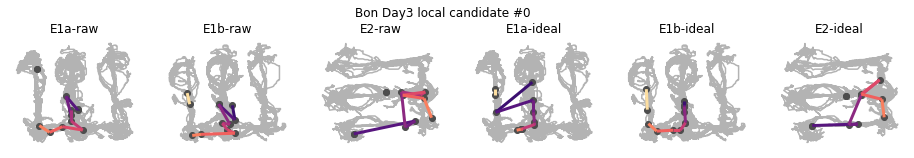

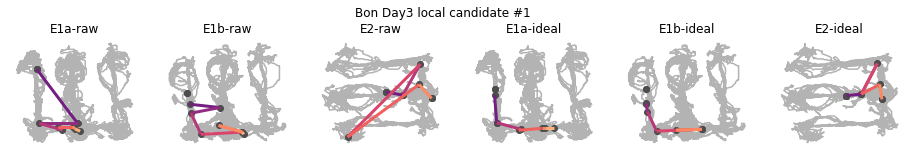

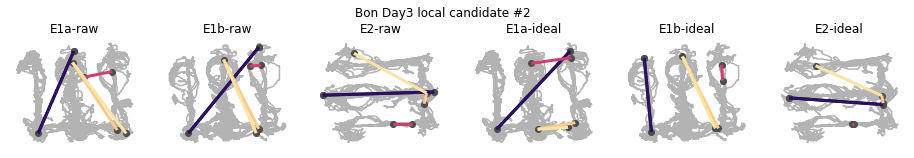

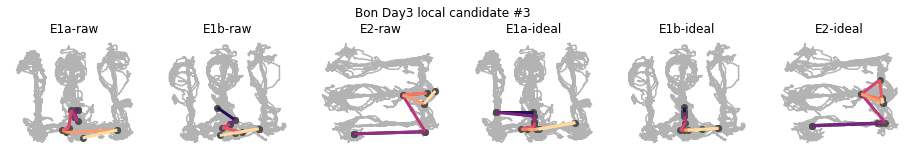

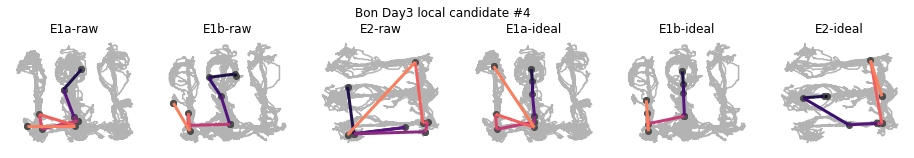

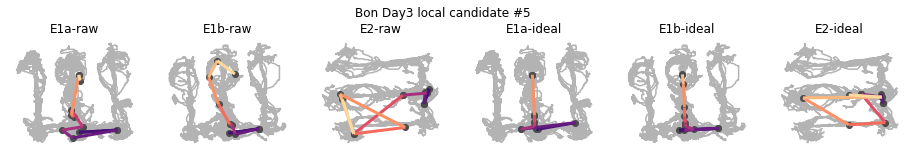

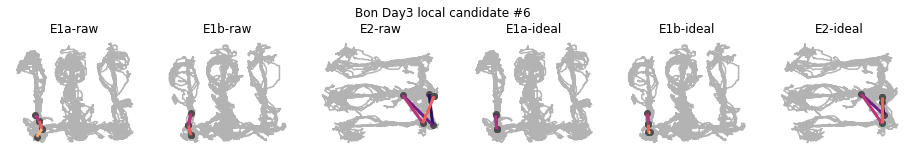

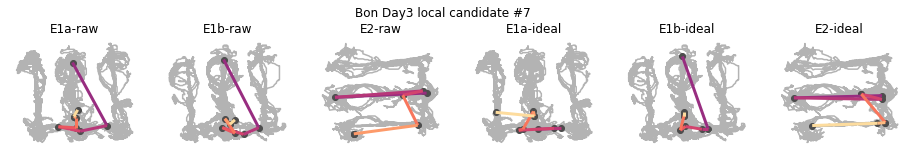

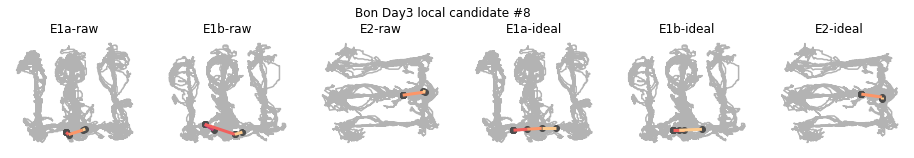

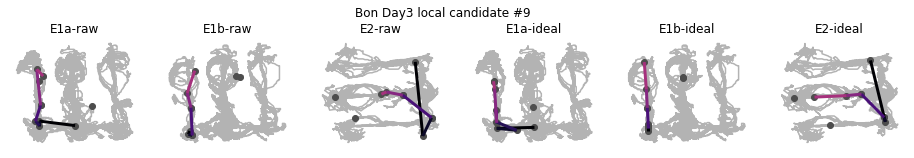

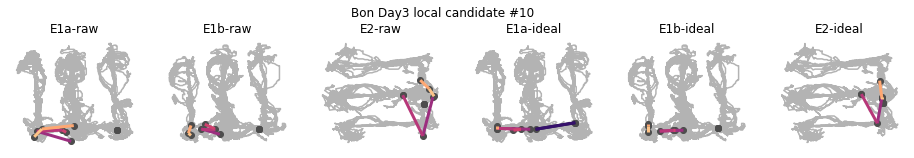

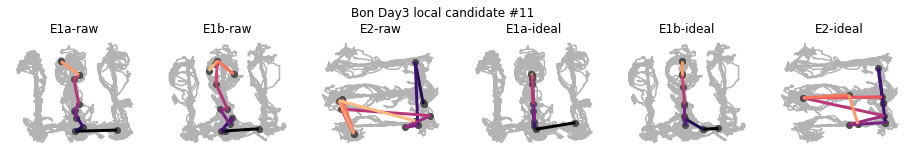

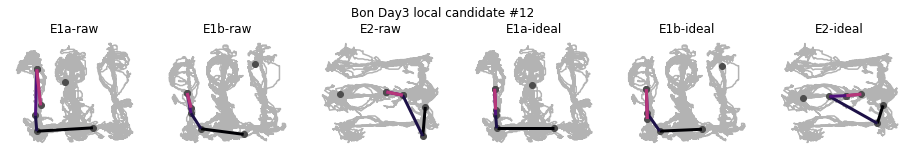

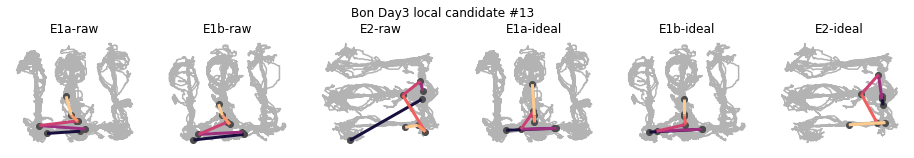

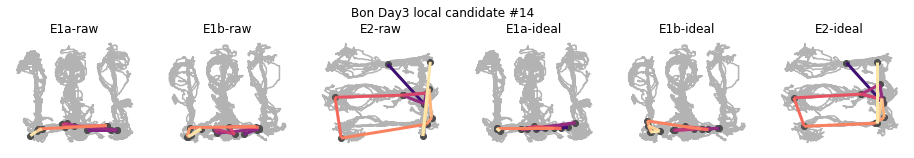

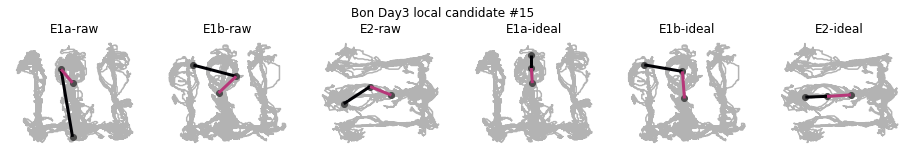

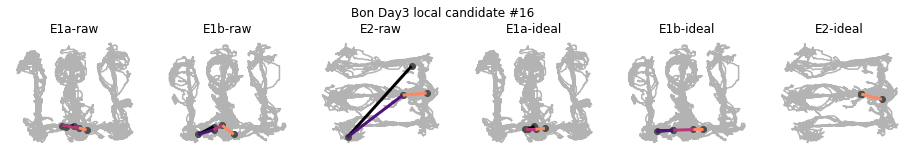

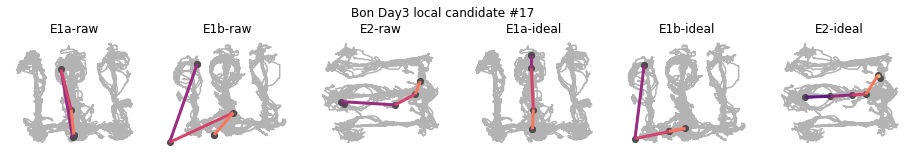

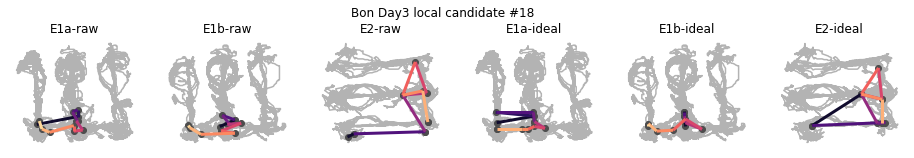

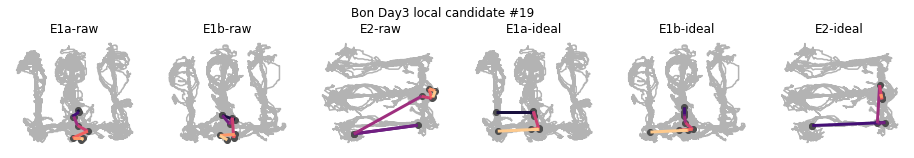

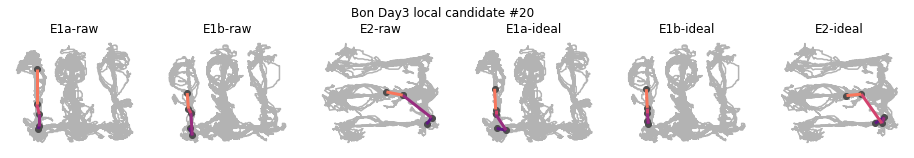

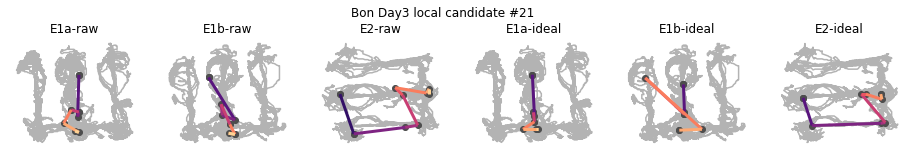

In [111]:
def plot_all_local_E2_events(data, animal, day):
    try:
        bst = data[animal][day]['remote_replay_E1_in_E2']['bst_local_candidates']
    except KeyError:
        raise UserWarning('The (animal, day) pair does not have remote replay analysis results...')
        return
    
    tc_E1a = data[animal][day]['tuning_curves2D'][E1a]
    tc_E1b = data[animal][day]['tuning_curves2D'][E1b]
    tc_E2 = data[animal][day]['tuning_curves2D'][E2]
    
    tc_E1a_ideal = data[animal][day]['tuning_curves2D_ideal'][E1a]
    tc_E1b_ideal = data[animal][day]['tuning_curves2D_ideal'][E1b]
    tc_E2_ideal = data[animal][day]['tuning_curves2D_ideal'][E2]
    
    pos_E1a = data['Bon']['Day3']['pos'][E1a]
    pos_E1b = data['Bon']['Day3']['pos'][E1b]
    pos_E2 = data['Bon']['Day3']['pos'][E2]

    for idx in range(bst.n_epochs):
        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16, 2))
        axes = (ax1, ax2, ax3, ax4, ax5, ax6)
        
        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E1a)
        npl.plot2d(pos_E1a, color='0.7', ax=ax1)
        ax1.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax1, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax1.set_title('E1a-raw')
        
        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E1b)
        npl.plot2d(pos_E1b, color='0.7', ax=ax2)
        ax2.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax2, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax2.set_title('E1b-raw')
        
        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E2)
        npl.plot2d(pos_E2, color='0.7', ax=ax3)
        ax3.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax3, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax3.set_title('E2-raw')
        
        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E1a_ideal)
        npl.plot2d(pos_E1a, color='0.7', ax=ax4)
        ax4.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax4, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax4.set_title('E1a-ideal')
        
        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E1b_ideal)
        npl.plot2d(pos_E1b, color='0.7', ax=ax5)
        ax5.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax5, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax5.set_title('E1b-ideal')

        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(bst=bst[idx], ratemap=tc_E2_ideal)
        npl.plot2d(pos_E2, color='0.7', ax=ax6)
        ax6.plot(mode_pth[0,:], mode_pth[1,:], 'o', color='0.3', markersize=6)
        npl.colorline(mode_pth[0,:], mode_pth[1,:], ax=ax6, cmap=plt.cm.magma, lw=3, cm_range=(0,1))
        ax6.set_title('E2-ideal')
        
        fig.suptitle('{} {} local candidate #{}'.format(animal, day, idx), y=1.1)
        
        for ax in axes:
            npl.utils.clear_left_right(ax)
            npl.utils.clear_top_bottom(ax)
            
        plt.show()

good_events = [17, ]
plot_all_local_E2_events(data=data, 
                         animal=animal,
                         day=day)

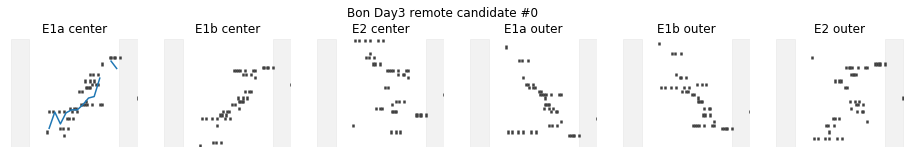

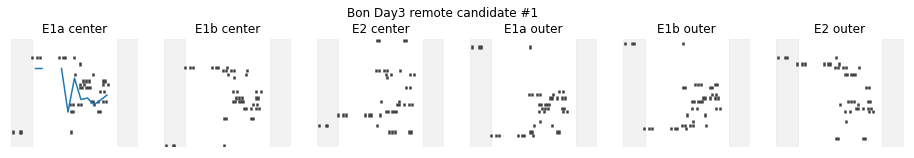

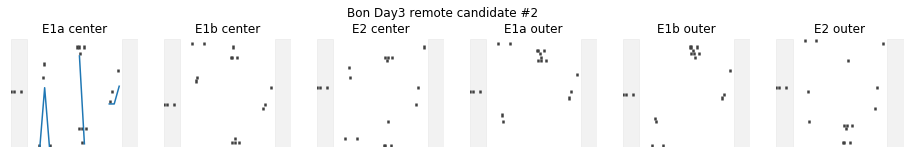

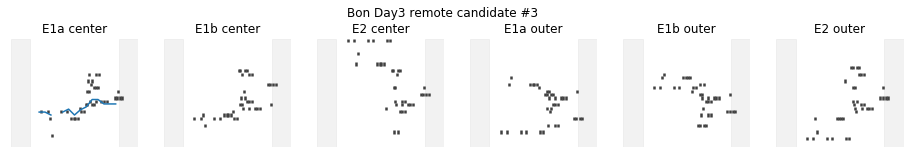

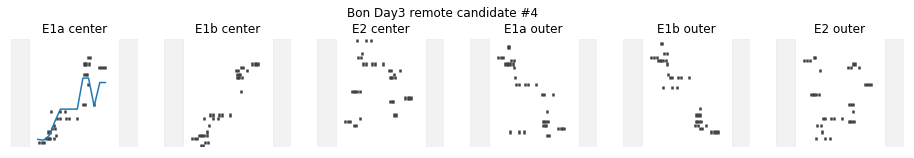

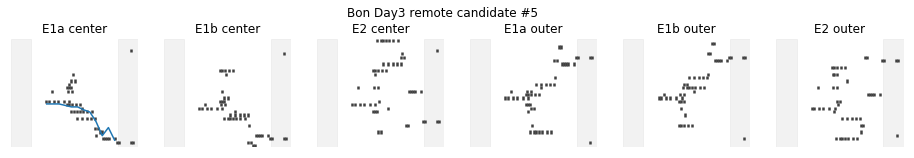

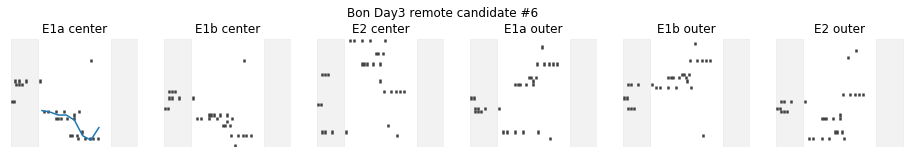

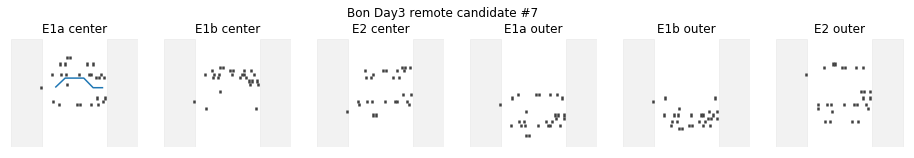

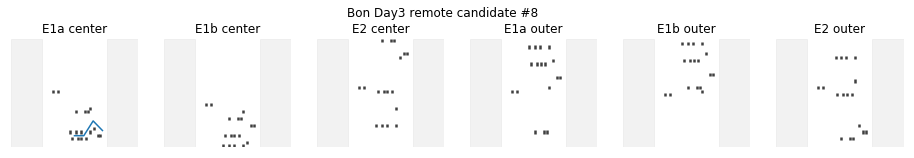

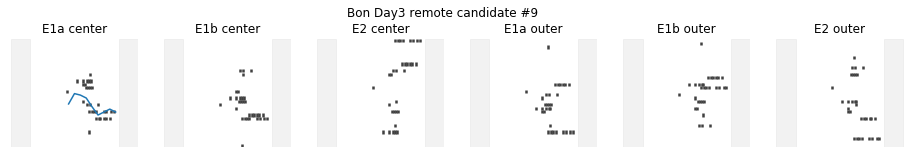

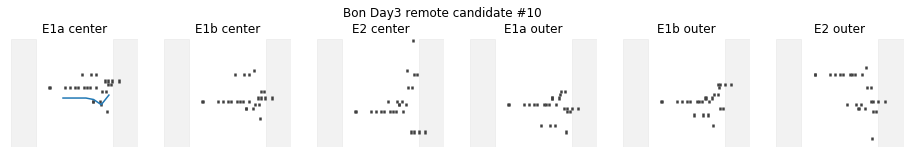

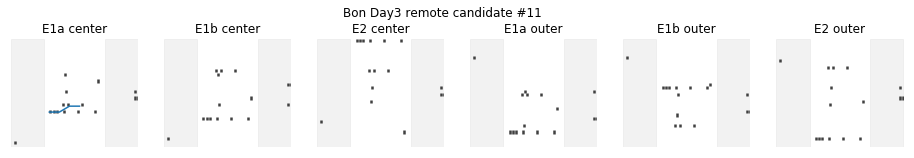

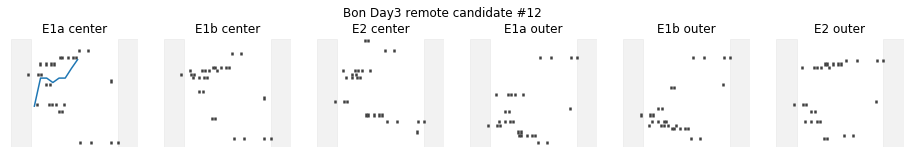

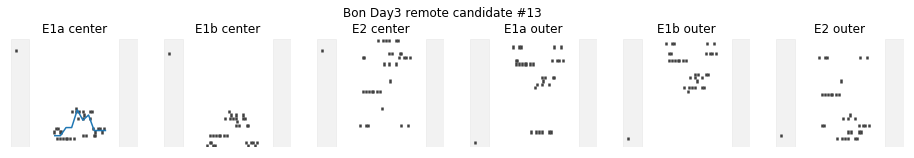

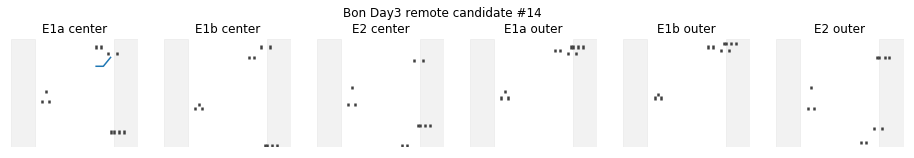

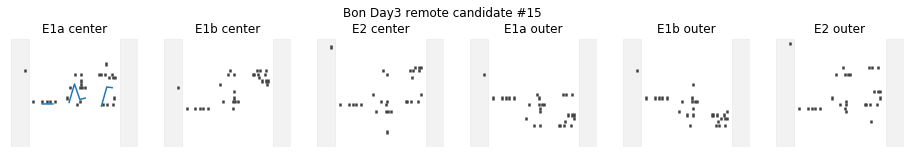

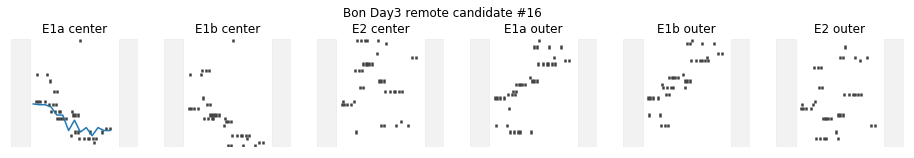

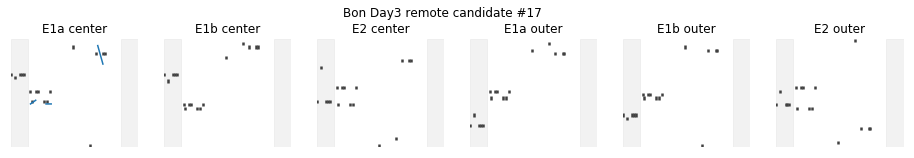

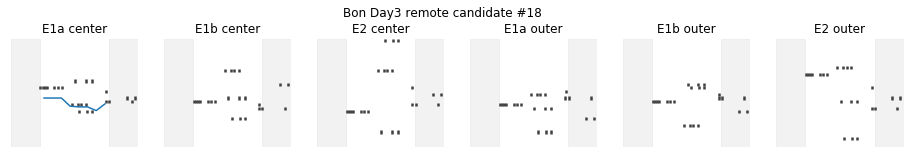

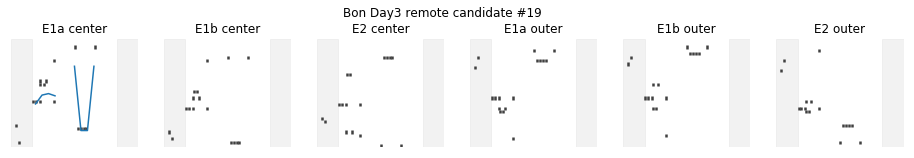

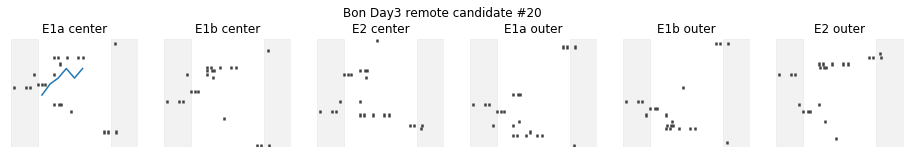

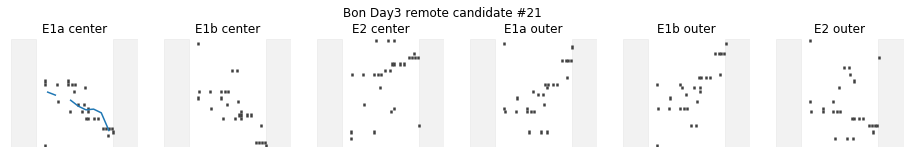

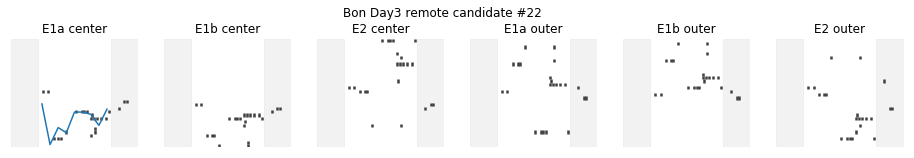

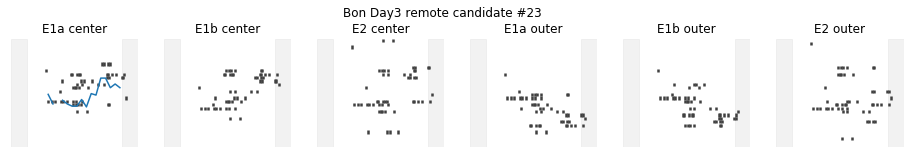

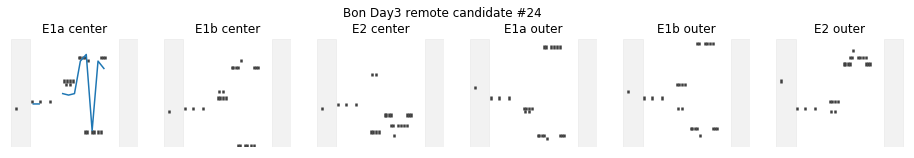

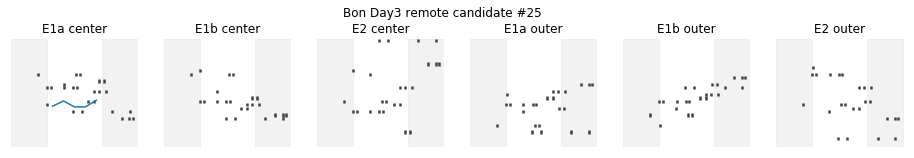

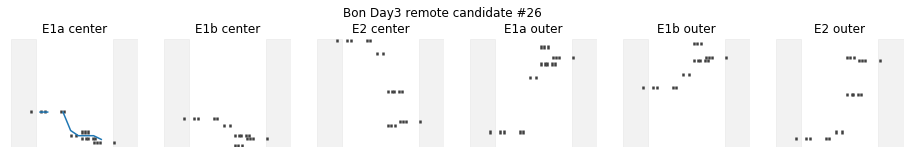

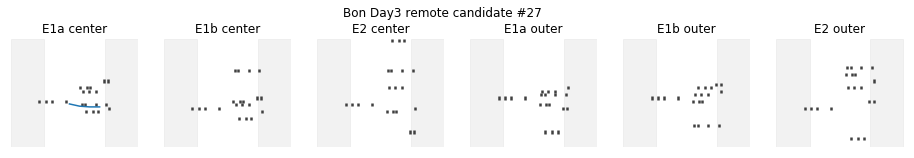

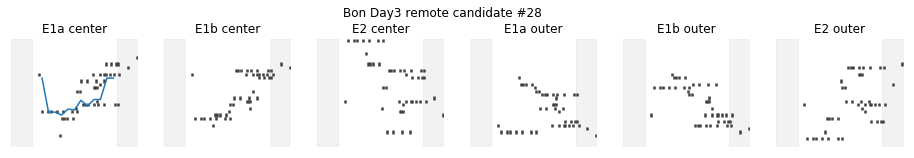

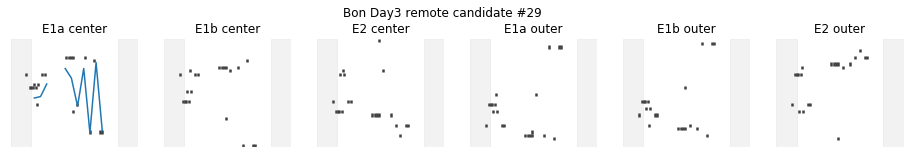

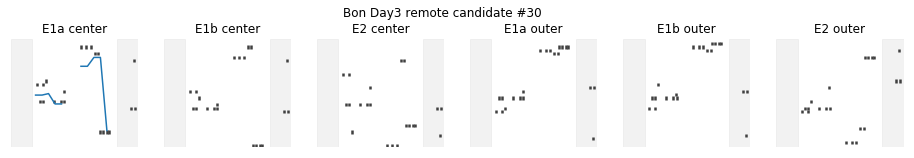

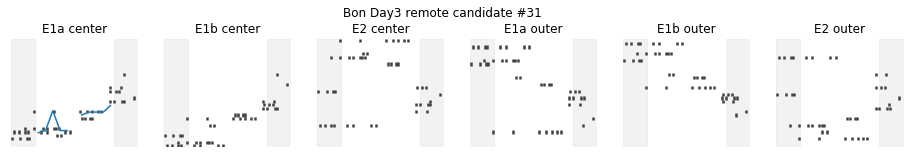

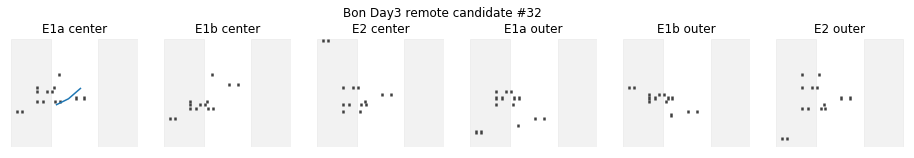

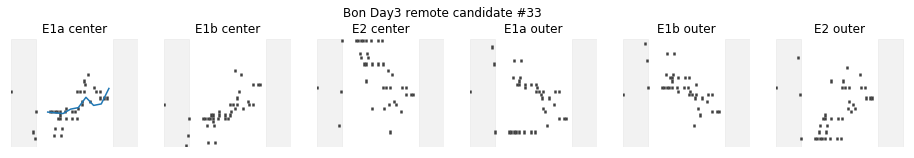

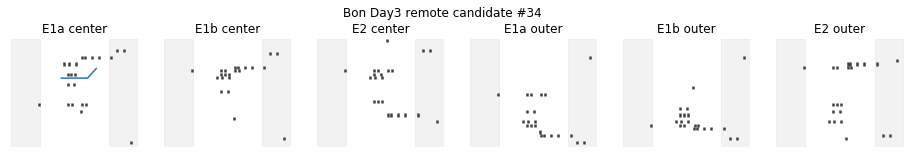

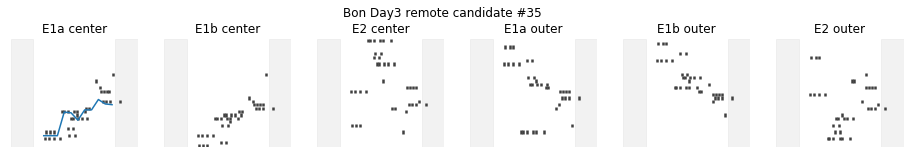

In [29]:
def plot_all_linearized_E2_remote_events(data, animal, day):
    try:
        bst = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates']
    except KeyError:
        raise UserWarning('The (animal, day) pair does not have remote replay analysis results...')
        return
    
    tc_E1a_co = data[animal][day]['tuning_curves1D_center'][E1a]
    tc_E1b_co = data[animal][day]['tuning_curves1D_center'][E1b]
    tc_E2_co = data[animal][day]['tuning_curves1D_center'][E2]
    
    tc_E1a_oo = data[animal][day]['tuning_curves1D_outer'][E1a]
    tc_E1b_oo = data[animal][day]['tuning_curves1D_outer'][E1b]
    tc_E2_oo = data[animal][day]['tuning_curves1D_outer'][E2]
    
    for evt_idx in range(bst.n_epochs):
        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16, 2))
        axes = (ax1, ax2, ax3, ax4, ax5, ax6)
        
        evt = bst[evt_idx]
        evt_extent = evt.support
        plot_extent = evt_extent.expand(0.05)
        
        st = data[animal][day]['remote_replay_E1_in_E2']['st_placecells_remote'][plot_extent]
        
        peak_order = tc_E1a_co._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax1)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax1)
        ax1.set_xlim(*st.support.time)
        ax1.set_title('E1a center')
        ymin, ymax = ax1.get_ylim()
        posterior, lengths, mode_pth, mean_pth = nel.decoding.decode1D(bst=evt, ratemap=tc_E1a_co)
        ax1.plot(evt.bin_centers, mode_pth*ymax / tc_E1a_co.bin_centers[-1])
        
        peak_order = tc_E1b_co._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax2)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax2)
        ax2.set_xlim(*st.support.time)
        ax2.set_title('E1b center')
        
        peak_order = tc_E2_co._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax3)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax3)
        ax3.set_xlim(*st.support.time)
        ax3.set_title('E2 center')

        peak_order = tc_E1a_oo._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax4)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax4)
        ax4.set_xlim(*st.support.time)
        ax4.set_title('E1a outer')
        
        peak_order = tc_E1b_oo._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax5)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax5)
        ax5.set_xlim(*st.support.time)
        ax5.set_title('E1b outer')
        
        peak_order = tc_E2_oo._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax6)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax6)
        ax6.set_xlim(*st.support.time)
        ax6.set_title('E2 outer')
        
        fig.suptitle('{} {} remote candidate #{}'.format(animal, day, evt_idx), y=1.1)
        
        for ax in axes:
            npl.utils.clear_left_right(ax)
            npl.utils.clear_top_bottom(ax)
            
        plt.show()

plot_all_linearized_E2_remote_events(data=data, 
                         animal=animal,
                         day=day)

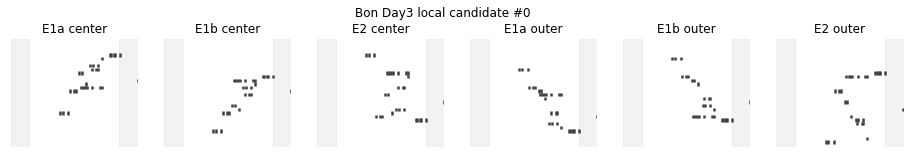

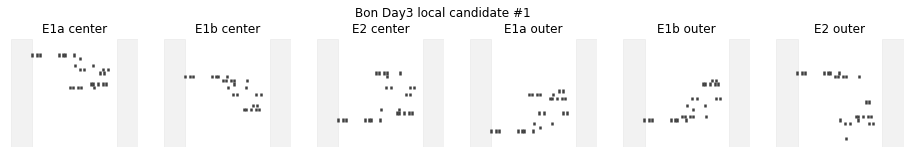

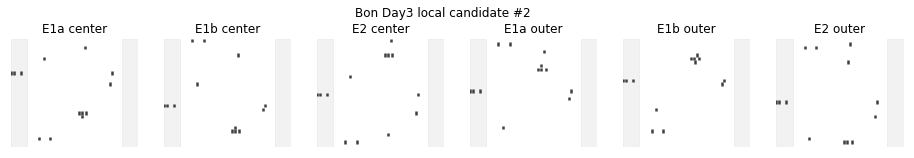

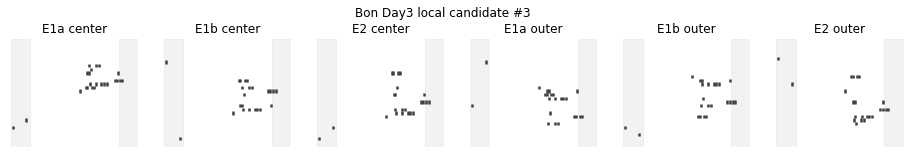

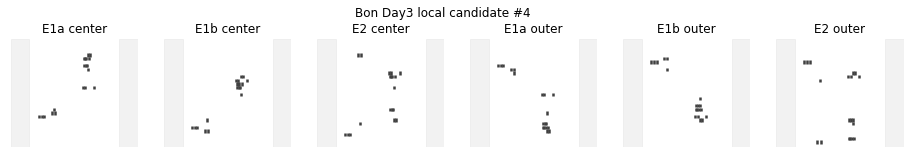

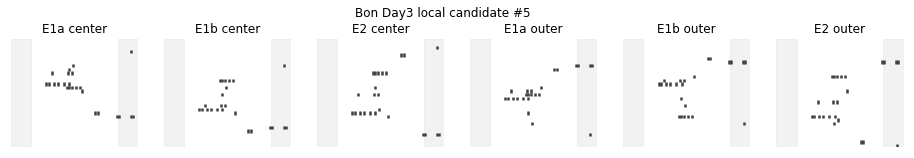

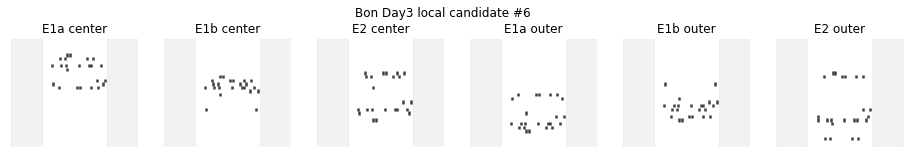

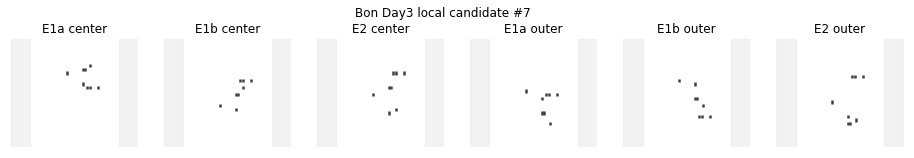

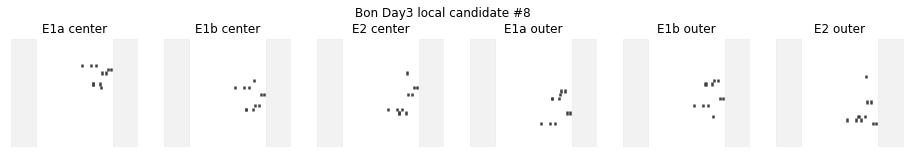

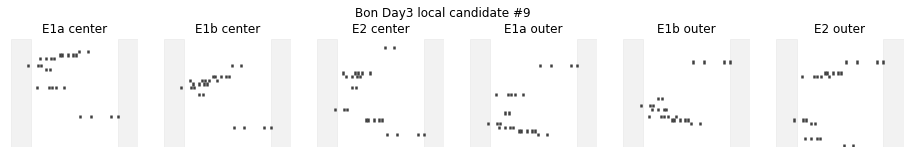

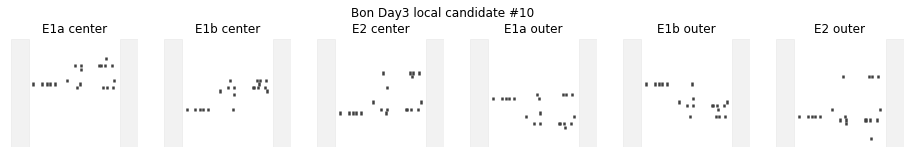

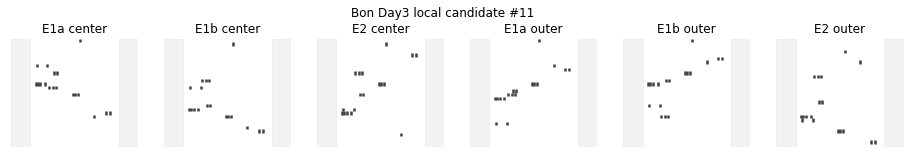

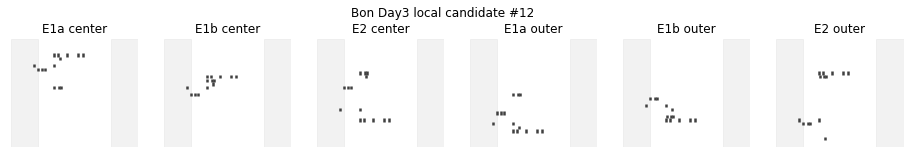

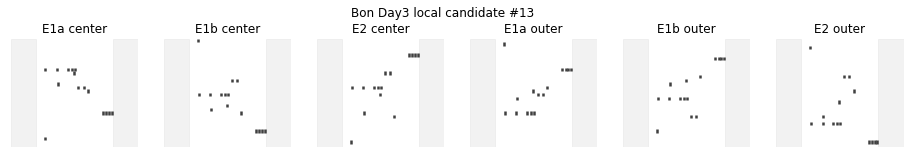

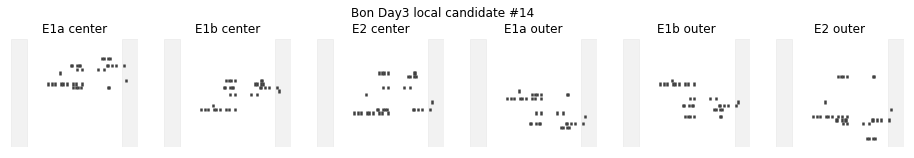

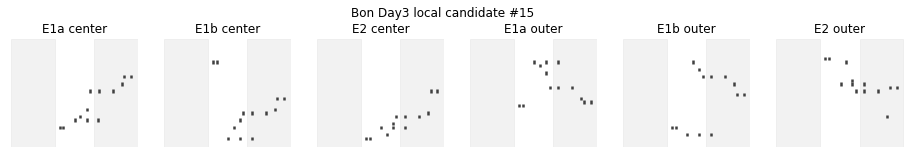

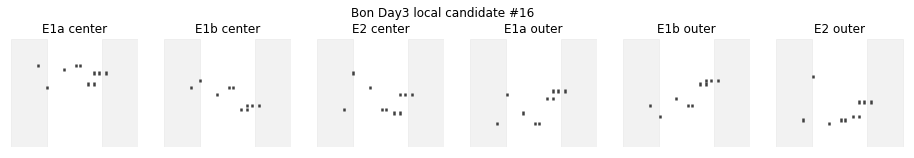

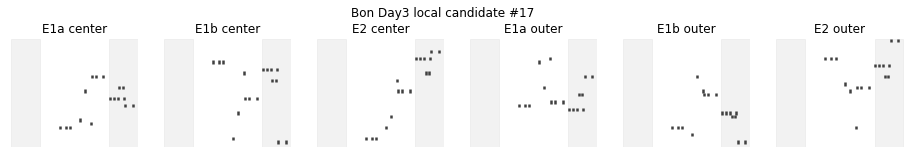

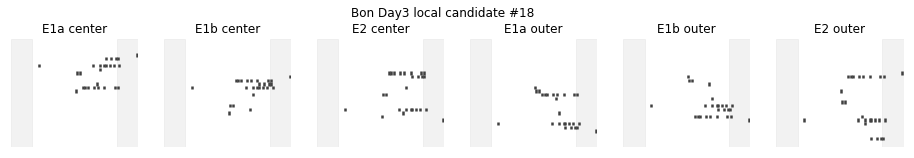

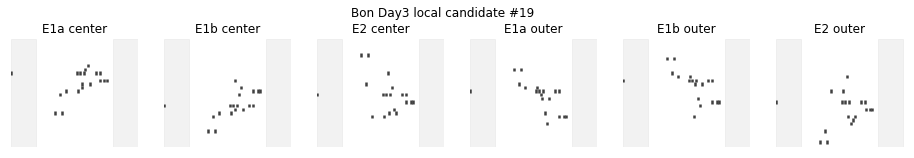

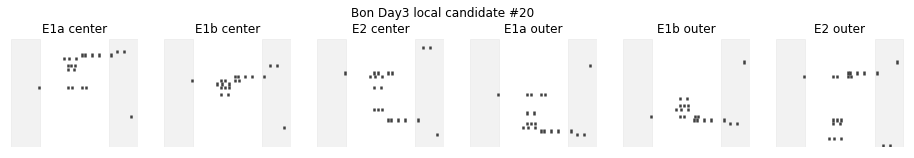

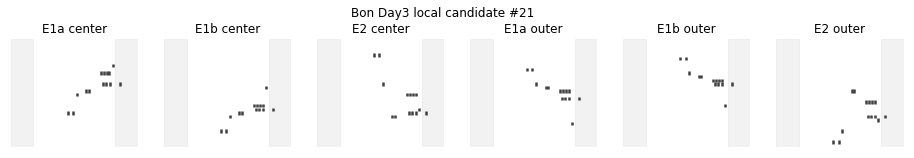

In [249]:
def plot_all_linearized_E2_local_events(data, animal, day):
    try:
        bst = data[animal][day]['remote_replay_E1_in_E2']['bst_local_candidates']
    except KeyError:
        raise UserWarning('The (animal, day) pair does not have remote replay analysis results...')
        return
    
    tc_E1a_co = data[animal][day]['tuning_curves1D_center'][E1a]
    tc_E1b_co = data[animal][day]['tuning_curves1D_center'][E1b]
    tc_E2_co = data[animal][day]['tuning_curves1D_center'][E2]
    
    tc_E1a_oo = data[animal][day]['tuning_curves1D_outer'][E1a]
    tc_E1b_oo = data[animal][day]['tuning_curves1D_outer'][E1b]
    tc_E2_oo = data[animal][day]['tuning_curves1D_outer'][E2]
    
    for evt_idx in range(bst.n_epochs):
        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16, 2))
        axes = (ax1, ax2, ax3, ax4, ax5, ax6)
        
        evt = bst[evt_idx]
        evt_extent = evt.support
        plot_extent = evt_extent.expand(0.05)
        
        st = data[animal][day]['remote_replay_E1_in_E2']['st_placecells_local'][plot_extent]
        
        peak_order = tc_E1a_co._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax1)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax1)
        ax1.set_xlim(*st.support.time)
        ax1.set_title('E1a center')
        
        peak_order = tc_E1b_co._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax2)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax2)
        ax2.set_xlim(*st.support.time)
        ax2.set_title('E1b center')
        
        peak_order = tc_E2_co._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax3)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax3)
        ax3.set_xlim(*st.support.time)
        ax3.set_title('E2 center')

        peak_order = tc_E1a_oo._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax4)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax4)
        ax4.set_xlim(*st.support.time)
        ax4.set_title('E1a outer')
        
        peak_order = tc_E1b_oo._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax5)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax5)
        ax5.set_xlim(*st.support.time)
        ax5.set_title('E1b outer')
        
        peak_order = tc_E2_oo._unit_subset(st.unit_ids).get_peak_firing_order_ids()
        npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5, ax=ax6)
        npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9', ax=ax6)
        ax6.set_xlim(*st.support.time)
        ax6.set_title('E2 outer')
        
        fig.suptitle('{} {} local candidate #{}'.format(animal, day, evt_idx), y=1.1)
        
        for ax in axes:
            npl.utils.clear_left_right(ax)
            npl.utils.clear_top_bottom(ax)
            
        plt.show()

plot_all_linearized_E2_local_events(data=data, 
                         animal=animal,
                         day=day)

# Decode some run bouts

In [30]:
raise NotImplementedError('run bouts have not been decoded yet :/')

NotImplementedError: run bouts have not been decoded yet :/